# **Final Project: Dog breed detector**

## **Import**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121, EfficientNetB7

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xml.etree.ElementTree as ET 
from PIL import Image
import tensorflow_datasets as tfds
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.12.0
keras version 2.12.0


## **Test GPU + RAM**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sun Jun 11 10:38:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Dog DataSet**

In [4]:
!rm -rf DatasetStore

In [5]:
import requests
import tarfile
dataset_path = "DatasetStore"

if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)
  
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

**Display some training images**

---



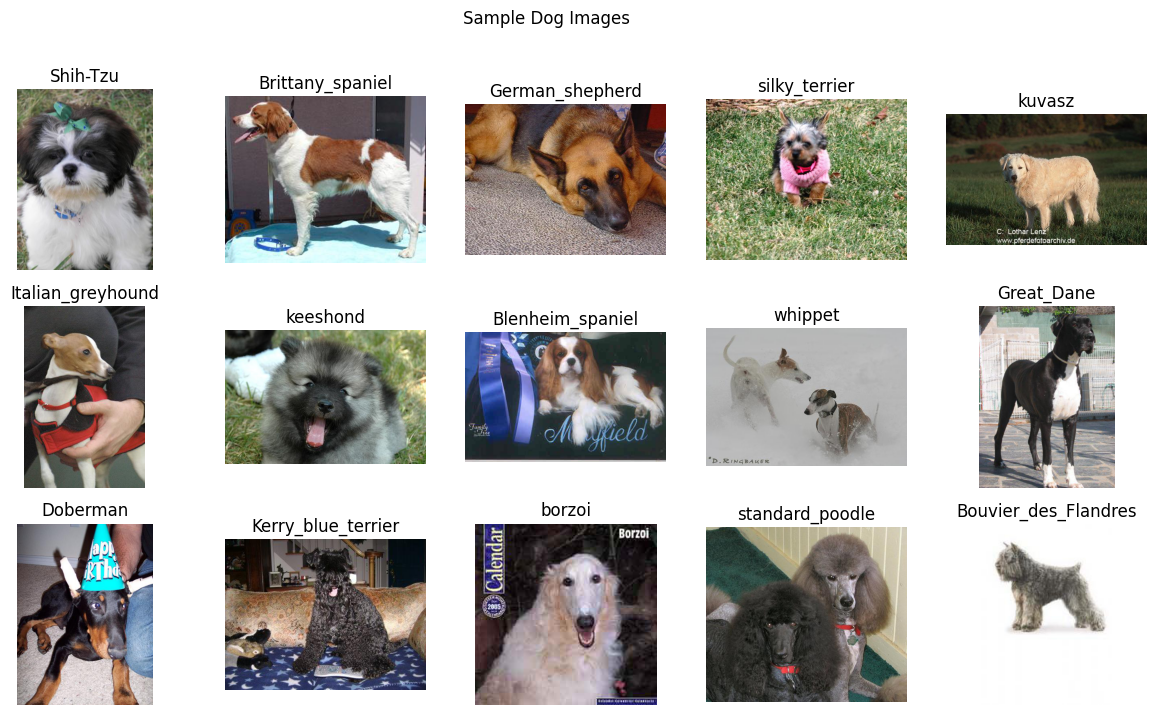

In [6]:
# https://www.kaggle.com/gtimoshaz/dataset-reading-demo

breed_list = os.listdir('DatasetStore/Annotation/') 

fig = plt.figure(figsize=(15,8))
for i in range(15):
    axs = fig.add_subplot(3,5,i+1)
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir('DatasetStore/Annotation/' + breed))
    img = Image.open('DatasetStore/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('DatasetStore/Annotation/' + breed + '/' + dog)
    root = tree.getroot() 
    object_1 = root.findall('object')[0];
    name = object_1.find('name').text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dog Images")
plt.show()

In [7]:
breed_list = os.listdir('DatasetStore/Annotation/'); 
breed_list.sort()
for i,breed in enumerate(breed_list):
  breed_list[i] = breed[10:];

label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
print(breed_list[:3])

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


**Load data**

In [8]:
breed_list = os.listdir('DatasetStore/Annotation/')
breed_list.sort()

label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('DatasetStore/Images/' + breed)
  image_files.sort()
  images.extend([os.path.join('DatasetStore/Images/',breed,f) for f in image_files])
  annotations.extend([os.path.join('DatasetStore/Annotation/',breed,f.replace(".jpg","")) for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2] 

Xs = np.asarray(images)
Ys = np.asarray(annotations)

print('Xs shape',Xs.shape)
print(Xs[:5])
print('Ys shape',Ys.shape)
print(Ys[:5])

train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

print("train_validate_x shape:",train_validate_x.shape)
print('train_validate_x[:5]:',train_validate_x[:5])
print("train_validate_y shape:",train_validate_y.shape)
print('train_validate_y[:5]:',train_validate_y[:5])

print("test_x shape:",test_x.shape)
print('test_x[:5]:',test_x[:5])
print("test_y shape:",test_y.shape)
print('test_y[:5]:',test_y[:5])

Xs shape (20580,)
['DatasetStore/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10621.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_1073.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10976.jpg']
Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua'
 'n02085620-Chihuahua' 'n02085620-Chihuahua']
train_validate_x shape: (18522,)
train_validate_x[:5]: ['DatasetStore/Images/n02102973-Irish_water_spaniel/n02102973_3195.jpg'
 'DatasetStore/Images/n02088238-basset/n02088238_7232.jpg'
 'DatasetStore/Images/n02105641-Old_English_sheepdog/n02105641_6534.jpg'
 'DatasetStore/Images/n02090721-Irish_wolfhound/n02090721_2319.jpg'
 'DatasetStore/Images/n02100583-vizsla/n02100583_2736.jpg']
train_validate_y shape: (18522,)
train_validate_y[:5]: ['n02102973-Irish_water_spaniel' 'n02088238-basset'
 'n02105641-Old_English_sheepdog' 'n020907

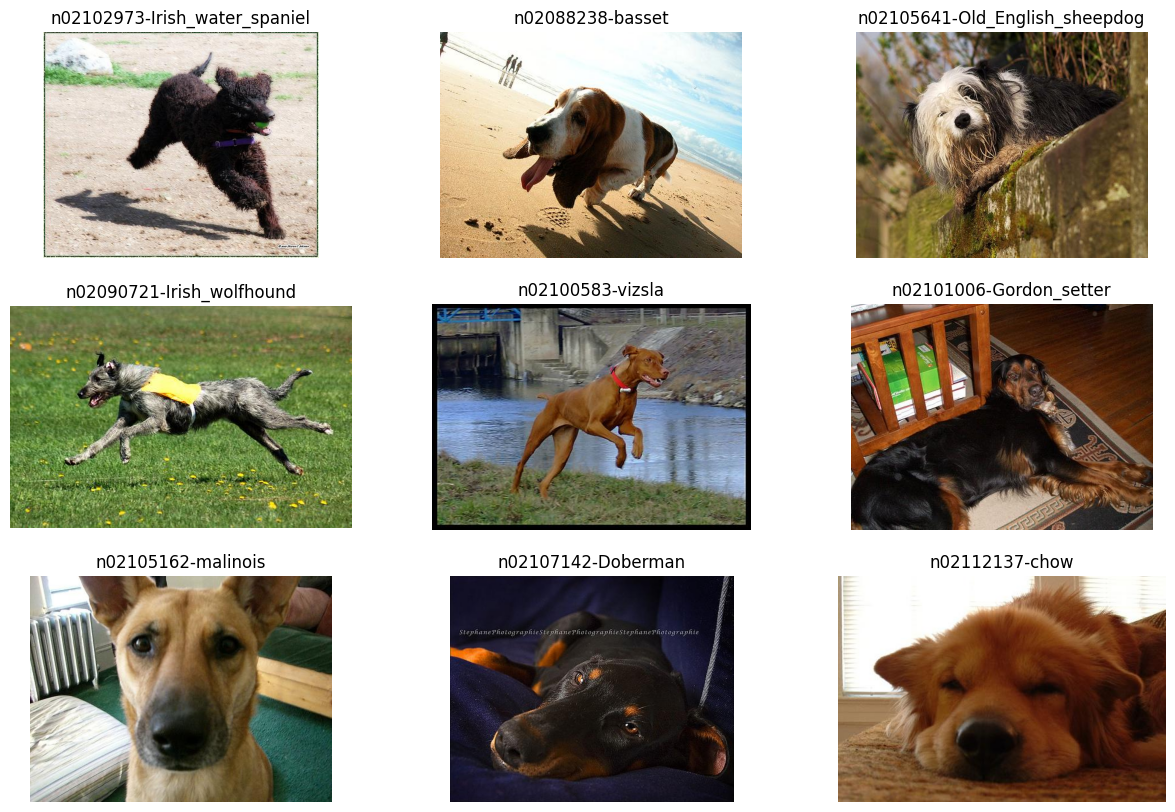

In [9]:
# View a few train images
fig = plt.figure(figsize=(15,10))

for idx in range(9):
  sample_input = cv2.imread(train_validate_x[idx])
  sample_input = cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB)
  breed = train_validate_y[idx];
  axs = fig.add_subplot(3,3,idx+1)
  axs.set_title(breed)
  plt.imshow(sample_input)
  plt.axis('off')

plt.show();



## **Build Data Generator**

In [10]:
validation_percent = 0.2
image_width = 600
image_height = 600
num_channels = 3
num_classes = len(breed_list);

epochs = 30
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3

train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent) 

train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = np.int(train_data_count / train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = np.int(validation_data_count / validation_batch_size)

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

def normalize(image, label):
    image = image/255
    return image, label 

def build_data_generators(train_data_process_list=[load_image,normalize],validate_data_process_list=[load_image,normalize],test_data_process_list=[load_image,normalize]):

    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))

    train_data = train_data.shuffle(train_data_count)
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
    
    train_data = train_data.repeat(epochs).batch(train_batch_size)

    validation_data = validation_data.shuffle(validation_data_count)
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)
    
    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)


    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)
    
    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

<ipython-input-10-089a49e89900>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  steps_per_epoch = np.int(train_data_count / train_batch_size)
<ipython-input-10-089a49e89900>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

train_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
validation_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
test_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


## **Utility Function**

In [11]:


class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)
        
def get_model_metrics():
    with open("./SavedModels/model_metrics.json") as json_file:
        model_metrics = json.load(json_file)
    
    return model_metrics

def save_model_metrics(model_name="model_1",metrics={}):
    if os.path.exists("./SavedModels/model_metrics.json"):
        with open("./SavedModels/model_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}
    
    model_metrics[model_name] = metrics
    
    with open("./SavedModels/model_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))
        
def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    model.save(os.path.join(path,model_name+".hdf5"))

    model.save_weights(os.path.join(path,model_name+".h5"))

    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):
    
    model_train_history = training_results.history
    num_epochs = len(model_train_history["loss"])

    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()
    
    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()
    
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)
    
    if save:
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        with open(os.path.join("./SavedModels",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

Compare all models

In [ ]:
# Compare model metrics
view_metrics = pd.read_json("./SavedModels/model_metrics.json")
view_metrics = view_metrics.T
# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)
2
view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
#view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)
print('Number of models:',view_metrics.shape[0])

FileNotFoundError: ignored

## **VGG16**
Use VGG16 as the base and fine tune the last conv2d block for our problem

### Build model

In [ ]:

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []
    
    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
            'trainable':layer.trainable
        })
    
    df = pd.DataFrame(layers_list)
    
    return df

layers_df = view_layers(vgg16)
print(layers_df[10:])

58892288/58889256 [==============================] - 1s 0us/step
           layer  trainable
10  MaxPooling2D       True
11        Conv2D       True
12        Conv2D       True
13        Conv2D       True
14  MaxPooling2D       True
15        Conv2D       True
16        Conv2D       True
17        Conv2D       True
18  MaxPooling2D       True


### Training params

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
batch_size = 32
epochs = 50

for layer in vgg16.layers[:-4]:
    layer.trainable = False

model_input = vgg16.layers[0].input

hidden = vgg16.layers[-1]
print("Pool Layer",hidden)

hidden = layers.Flatten()(hidden.output)

hidden = layers.Dense(units=1024, activation='relu')(hidden)
hidden = layers.Dense(units=1024, activation='relu')(hidden)

output = layers.Dense(units=num_classes, activation='softmax')(hidden)

model = Model(model_input, output, name='VGG16')

optimizer = optimizers.SGD(lr=learning_rate)

loss = losses.categorical_crossentropy

model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

layers_df = view_layers(model)
print(layers_df.head(25))



Pool Layer <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc517d55a20>
           layer  trainable
0     InputLayer      False
1         Conv2D      False
2         Conv2D      False
3   MaxPooling2D      False
4         Conv2D      False
5         Conv2D      False
6   MaxPooling2D      False
7         Conv2D      False
8         Conv2D      False
9         Conv2D      False
10  MaxPooling2D      False
11        Conv2D      False
12        Conv2D      False
13        Conv2D      False
14  MaxPooling2D      False
15        Conv2D       True
16        Conv2D       True
17        Conv2D       True
18  MaxPooling2D       True
19       Flatten       True
20         Dense       True
21         Dense       True
22         Dense       True


### Train model

In [ ]:

earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

checkpoint_filepath = './Checkpoints/checkpoint_VGG16'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=epochs, 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/50
463/463 [==============================] - ETA: 0s - loss: 4.7900 - accuracy: 0.0126
Epoch 00001: val_accuracy improved from -inf to 0.01739, saving model to ./Checkpoints/checkpoint_VGG16
463/463 [==============================] - 22s 47ms/step - loss: 4.7900 - accuracy: 0.0126 - val_loss: 4.7504 - val_accuracy: 0.0174
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 4.6613 - accuracy: 0.0320
Epoch 00002: val_accuracy improved from 0.01739 to 0.03614, saving model to ./Checkpoints/checkpoint_VGG16
463/463 [==============================] - 20s 44ms/step - loss: 4.6613 - accuracy: 0.0320 - val_loss: 4.6212 - val_accuracy: 0.0361
Epoch 3/50
462/463 [============================>.] - ETA: 0s - loss: 4.3588 - accuracy: 0.0760
Epoch 00003: val_accuracy improved from 0.03614 to 0.07337, saving model to ./Checkpoints/checkpoint_VGG16
463/463 [==============================] - 20s 44ms/step - loss: 4.3578 - accuracy: 0.0762 - val_loss: 4.2746 - val_accuracy: 0.

### Evaluate and Save

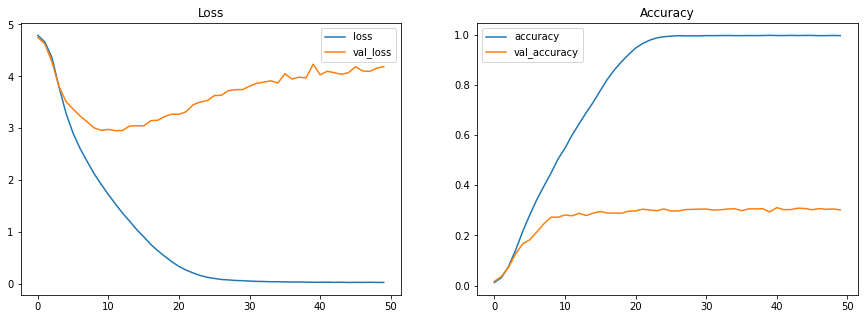

65/65 [==============================] - 1s 22ms/step - loss: 3.9470 - accuracy: 0.3246
Evaluation results: [loss, accuracy] [3.947021722793579, 0.32458698749542236]


In [ ]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## **EfficientNet with Adam optimizer**

In [ ]:
efficientnet = EfficientNetB7(
    include_top=False,
    input_shape=(600, 600, 3)
)

258076736/258076736 [==============================] - 6s 0us/step


### Build model

In [12]:
def build_efficient_model(model_name = 'EfficientNetB7',print_summary=True):
  for layer in efficientnet.layers:
      layer.trainable = False

  model_input = efficientnet.layers[0].input

  hidden = efficientnet.layers[-1]

  hidden = layers.Flatten()(hidden.output)

  output = layers.Dense(units=120, activation='softmax')(hidden)

  model = Model(model_input, output, name=model_name)

  if print_summary:
    print(model.summary())

  return model

### Training params

In [14]:
# Training Params

batch_size = 32
epochs = 50 


earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

checkpoint_filepath = './Checkpoints/checkpoint_EfficientNetB7'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

model = build_efficient_model()

optimizer = optimizers.Adam()

loss = losses.categorical_crossentropy

model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])




NameError: ignored

### Train model

In [ ]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback], 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



## Add data augmentation to ResNet50V2

In [ ]:

def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label

def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

data_process_list=[load_image, normalize, adjust_brightness, adjust_contrast]

train_data, validation_data, test_data = build_data_generators(train_data_process_list=data_process_list)
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
validation_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
test_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


### Build model

In [ ]:
############################
# Training Params
############################
batch_size = 32
epochs = 50

earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2DataAug'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

model = build_resnet_model(model_name='ResNet50V2_DataAug')

checkpoint_path = './Checkpoints/checkpoint_ResNet50V2'
model.load_weights(checkpoint_path)

optimizer = optimizers.Adam()

loss = losses.categorical_crossentropy

model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])





Model: "ResNet50V2_DataAug"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][

### Train model

In [ ]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/50
462/463 [============================>.] - ETA: 0s - loss: 1.6759 - accuracy: 0.9693
Epoch 1: val_accuracy improved from -inf to 0.43179, saving model to ./Checkpoints/checkpoint_ResNet50V2DataAug
463/463 [==============================] - 40s 79ms/step - loss: 1.6775 - accuracy: 0.9693 - val_loss: 91.4387 - val_accuracy: 0.4318
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 1.4552 - accuracy: 0.9744
Epoch 2: val_accuracy improved from 0.43179 to 0.44239, saving model to ./Checkpoints/checkpoint_ResNet50V2DataAug
463/463 [==============================] - 30s 66ms/step - loss: 1.4552 - accuracy: 0.9744 - val_loss: 88.1119 - val_accuracy: 0.4424
Epoch 3/50
463/463 [==============================] - ETA: 0s - loss: 1.1669 - accuracy: 0.9755
Epoch 3: val_accuracy improved from 0.44239 to 0.45000, saving model to ./Checkpoints/checkpoint_ResNet50V2DataAug
463/463 [==============================] - 31s 68ms/step - loss: 1.1669 - accuracy: 0.9755 - val_loss:

### Evaluate and Save

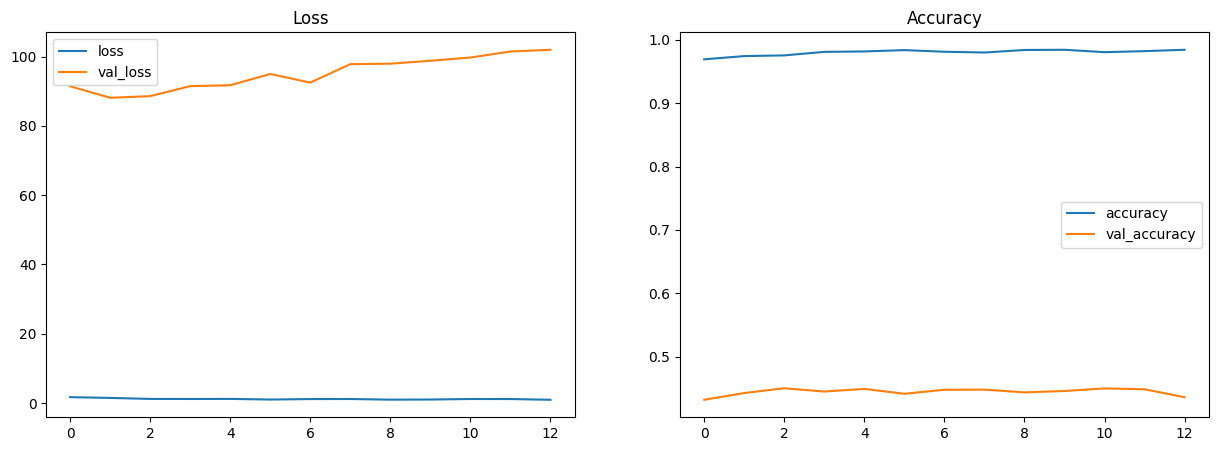

65/65 [==============================] - 5s 71ms/step - loss: 107.8402 - accuracy: 0.4193
Evaluation results: [loss, accuracy] [107.84015655517578, 0.4193391501903534]


In [ ]:
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Display predictions

In [ ]:
prediction_model = tf.keras.models.load_model('./SavedModels/ResNet50V2_DataAug.hdf5')
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2DataAug'
prediction_model.load_weights(checkpoint_path)

test_predictions = prediction_model.predict(test_data)

test_x_display = []
for path in test_x:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_x_display.append(image)

test_x_display = np.asarray(test_x_display)

true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))
for i,file in enumerate(test_x_display[:50]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] 
    true_breed = test_y[i][10:]
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green')
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
    plt.imshow(test_x_display[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)

OSError: ignored

In [15]:

model = EfficientNetB7(weights='imagenet')


268326632/268326632 [==============================] - 5s 0us/step


In [20]:
img_path = './DatasetStore/Images/small-fluff.jpg'  
img = image.load_img(img_path, target_size=(600, 600))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
decoded_preds = decode_predictions(preds, top=3)[0]

for pred in decoded_preds:
    print(f'{pred[1]}: {pred[2]*100:.2f}% confidence')


1/1 [==============================] - 0s 73ms/step
Pomeranian: 69.26% confidence
keeshond: 1.41% confidence
chow: 0.51% confidence


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224, 224, 3)

resnet_model = ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')
test_dir = "./DatasetStore/Images"
train_dir = "./DatasetStore/Images"
for layer in resnet_model.layers:
    layer.trainable = False

model = tf.keras.models.Sequential()
model.add(resnet_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[earlystopping, model_checkpoint_callback]
)




Found 20580 images belonging to 120 classes.
Epoch 1/50
643/643 [==============================] - ETA: 0s - loss: 1.6894 - accuracy: 0.5540

643/643 [==============================] - 298s 455ms/step - loss: 1.6894 - accuracy: 0.5540
Epoch 2/50
643/643 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.6590

643/643 [==============================] - 294s 457ms/step - loss: 1.1598 - accuracy: 0.6590
Epoch 3/50
643/643 [==============================] - ETA: 0s - loss: 1.0620 - accuracy: 0.6881

643/643 [==============================] - 294s 457ms/step - loss: 1.0620 - accuracy: 0.6881
Epoch 4/50
643/643 [==============================] - ETA: 0s - loss: 0.9757 - accuracy: 0.7051

643/643 [==============================] - 295s 458ms/step - loss: 0.9757 - accuracy: 0.7051
Epoch 5/50
 26/643 [>.............................] - ETA: 4:46 - loss: 0.8727 - accuracy: 0.7428

KeyboardInterrupt: ignored

In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator)

Found 20580 images belonging to 120 classes.
644/644 [==============================] - 298s 461ms/step
